In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.widgets import Slider, Button
# %matplotlib nbagg # use "%matplotlib widget" if on jupyter-lab
%matplotlib widget

## Introduction

So far, we have been using a non-parametric model with KNN, meaning we needed access to the whole training dataset for each prediction. We will now focus on parametric models, namely linear regression and generalized linear regression (GLR). Parametric models are defined by a finite set of parameters, which are calibrated in a training step. All we need for a prediction then is the parameter values. There is no longer a need to carry the whole dataset with us; all the information is encoded in the model parameters.

## Linear model

Even though the linear model is linear in its inputs, the key idea is that linear regression models, and generalized linear regression models are linear in their parameters, referred to the following as $\mathbf{w}$. The simplest approach is to model our target function $y(x)$ as a linear combination of the coordinates $x$:

$$ y(x,\mathbf{w}) = w_0 + w_1 x_1 $$

In the one dimensional case, this is equivalent to fitting a line through our datapoints. The parameter $w_0$, also referred to as bias (not to be confused with the model bias), determines the intercept, $w_1$ determines the slope. The introduction of a dummy input $x_0 = 1$ allows us to write the model in a more concise way:

$$ y(x,\mathbf{w}) = w_0 x_0 + w_1 x_1 = \mathbf{w}^T \mathbf{x}$$

Let us define a few things we need to generate the data and fit the model first, and then see how this model performs. Once again, we employ the sine wave from the previous notebooks and generate a dataset consisting of $N$ noisy observations of the true process.

$$ t = y( x, \mathbf w ) + \epsilon \hspace{0.6cm} \mathrm{with} \hspace{0.6cm} \epsilon \sim \mathcal{N} (0,\beta^{-1}) $$

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
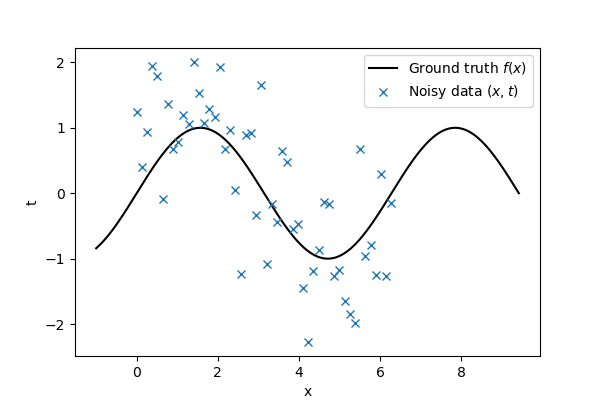

In [2]:
# The true function relating t to x
def f (x, l=2*np.pi):
    return np.sin(x*2*np.pi/l)

# Define the number of measurements, and how noisy they are
N = 50
noise = 0.7

# Use a seed, to ensure that the results are reproducible
seed = 0
np.random.seed(seed)

# Define two linspaces along x
# x_pred --> locations where we want to make predictions, i.e. everywhere
# x      --> locations where we observe data
x_pred = np.linspace(-1, 3*np.pi, 1000)
x = np.linspace(0, 2*np.pi, N)

# Generate the observed data
t = f(x) + np.random.normal(0, noise, N)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

Recall that the square loss function for our linear regression model is

$$L =  \frac{1}{2} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x}_n \big)^2 $$

We obtain optimal parameters values $\bar{\mathbf{w}}$ by setting the gradient of our loss function w.r.t. $\mathbf{w}$ to zero and solving for $\mathbf{w}$.

$$ \nabla_{\mathbf{w}} L = \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x} \big) \mathbf{x}  \stackrel{!}{=} 0 $$

It is convenient to concatenate all inputs to a *design matrix* $\mathbf{X} = [\mathbf{x}_1^T, ..., \mathbf{x}_N^T]^T$. Solving for $\mathbf{w}$ gives

$$ \bar{\mathbf{w}} = \big( \mathbf{X}^T \mathbf{X} \big)^{-1} \mathbf{X}^T \mathbf{t} $$

In [3]:
# Implementation of the basis functions
class LinearBasis(object):
    """
    Represents a 1D linear basis.
    """
    def __init__(self):
        self.num_basis = 2 # The number of basis functions is 2 due to the dummy input
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        x = x.reshape(-1,1)
        return np.hstack((np.ones_like(x),x))

In [4]:
# Let's test out implementation
phi_lin = LinearBasis()
phi_lin(np.arange(0,5))

array([[1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4]])

In [5]:
# Now we need a generic function that solves the least squares problem for us
def solve_least_squares(X, t, phi):
    """
    Arguments:
    X   -  The observed inputs (1D array)
    t   -  The observed targets (1D array)
    phi -  The basis functions.
    """
    
    Phi = phi(X)
    t = t.reshape(-1,1)
    
    return np.linalg.solve(Phi.T @ Phi, Phi.T @ t)

We are **not** inverting $\boldsymbol{X}^T \boldsymbol{X}$, which is extremely expensive for large amounts of data. A more efficient way to obtain $\mathbf{w}$ is to solve $\boldsymbol{X}^T \boldsymbol{X} \mathbf{w} = \boldsymbol{X}^T \mathbf{t}$. It is important to note that this approach only works for a well defined system of equations, i.e.
$\boldsymbol{X}^T \boldsymbol{X}$ must be of full rank.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
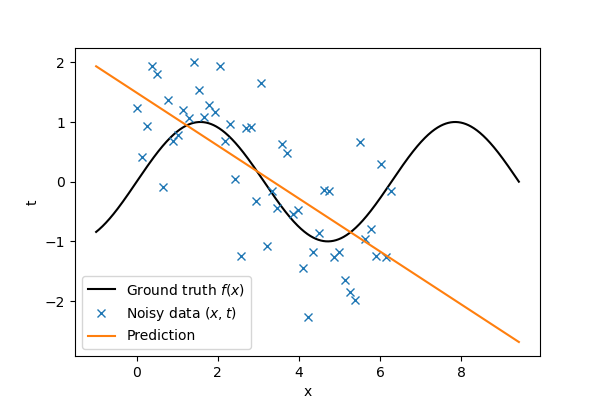

In [6]:
# Let's run our model with linear basis funcitons and plot the results
w_lin = solve_least_squares(x, t, phi_lin)
Phi_pred = phi_lin(x_pred)
y = np.matmul(Phi_pred, w_lin)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.plot(x_pred, y, '-', label=r'Prediction')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

It is clear from the plot that a linear model with linear features lacks the flexibility to fit the data well. A bias-variance decomposition would show that the model has little variance but shows a strong bias. We now consider nonlinear functions of the input $x$ as features/regressors to increase the flexibility of our linear model. A common approach is to use a set of polynomial basis functions,

$$ \phi_j(x) = x^j, $$

but numerous other choices are possible. We only need to ensure that we have more data points than basis functions for the problem to be well defined and that the basis functions are linearly independent. The design matrix for this more general case writes

$$ \Phi_{ij} = \phi_j(x_i). $$

Let's implement a `PolynomialBasis` class.

In [7]:
# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        """
        ``x`` should be a 1D array.
        """
        return np.array([x ** i for i in range(self.degree + 1)]).transpose()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
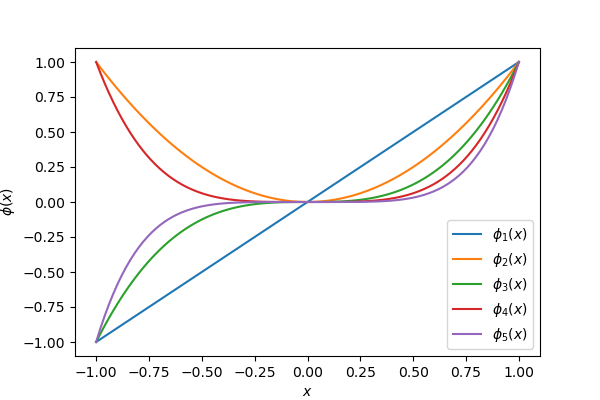

In [8]:
# Let's test our implementation and visualize the polynomial basis functions
degree = 5
phi_poly_test = PolynomialBasis(degree)
x_test = np.linspace(-1,1,100)
Phi_p_test = phi_poly_test(x_test)[:,1::]

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

for i, row in enumerate(Phi_p_test.transpose()):
    plt.plot(x_test, row, label=r'$\phi_{}(x)$'.format(i + 1))
    
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend()
plt.show()

We obtain the generalized linear model (GLM) by replacing the coordinate vector $x$ by the  feature vector $\boldsymbol{\phi}(x)$

$$ y(x,\mathbf{w}) = \sum_{j=0}^M = w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

The solution procedure remains the same, and we can solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.$$

Let's take a look a the GLR model with polynomial regressors.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
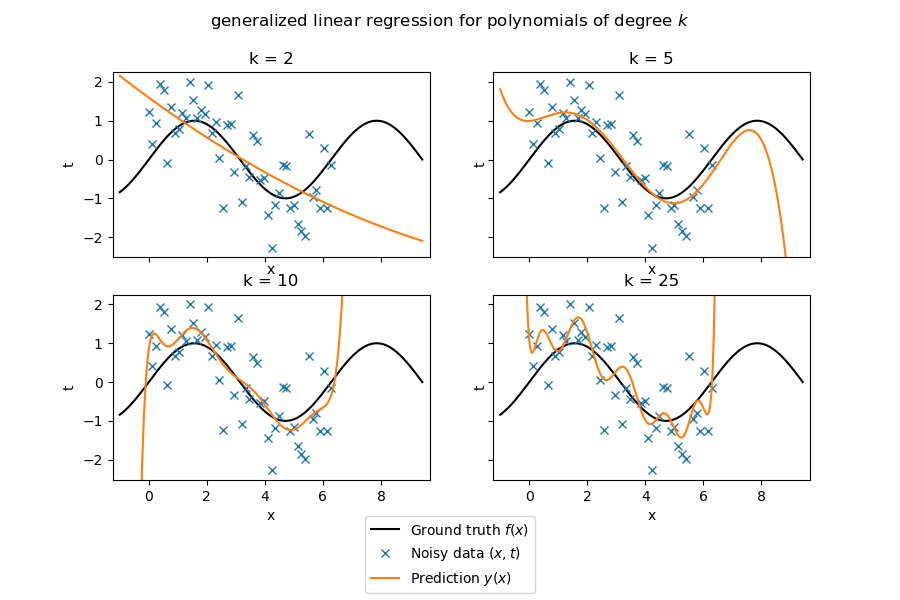

In [9]:
# Let's test our implementation and test the polynomial basis functions
degree = 2
phi_poly = PolynomialBasis(degree)
w_poly = solve_least_squares(x, t, phi_poly)
Phi_pred = phi_poly(x_pred)
y_2 = np.matmul(Phi_pred, w_poly)

degree = 5
phi_poly = PolynomialBasis(degree)
w_poly = solve_least_squares(x, t, phi_poly)
Phi_pred = phi_poly(x_pred)
y_5 = np.matmul(Phi_pred, w_poly)

degree = 10
phi_poly = PolynomialBasis(degree)
w_poly = solve_least_squares(x, t, phi_poly)
Phi_pred = phi_poly(x_pred)
y_10 = np.matmul(Phi_pred, w_poly)

degree = 24
phi_poly = PolynomialBasis(degree)
w_poly = solve_least_squares(x, t, phi_poly)
Phi_pred = phi_poly(x_pred)
y_25 = np.matmul(Phi_pred, w_poly)

# Define a function that creates a plot
def plot_pred(ax, y_k, k):
    
    margin = 0.25
    ax.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
    ax.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
    ax.plot(x_pred, y_k, '-', label=r'Prediction $y(x)$'.format(k))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title('k = {}'.format(k))
    ax.set_xlim([np.min(x_pred) - margin, np.max(x_pred) + margin])
    ax.set_ylim([np.min(t) - margin, np.max(t) + margin])

# Plot the resulting predictions
# tight_layout=True or constrained_layout=True does not play nice with the legend :(
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for polynomials of degree $k$')

# Plot for k=1
plot_pred(ax[0][0], y_2, 2)

# Plot for k=10
plot_pred(ax[0][1], y_5, 5)

# Plot for k=30
plot_pred(ax[1][0], y_10, 10)

# Plot for k=100
plot_pred(ax[1][1], y_25, 25)

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

That is looking much better already. However, the quality of the fit varies significantly with the degree of the polynomial basis. There seems to be an ideal model complexity for this specific problem. Try out the interactive tool below to get an idea of the interplay of the following variables:
- $N$, degree of the polynomial basis
- $N$, the size of the training data set
- $l$, the wavelength of the underlying truth
- $\varepsilon$, the level of noise associated with the data
- The seed can be updated to generate new random data sets
- The truth can be hidden to simulate a situation that is closer to a practical setting

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
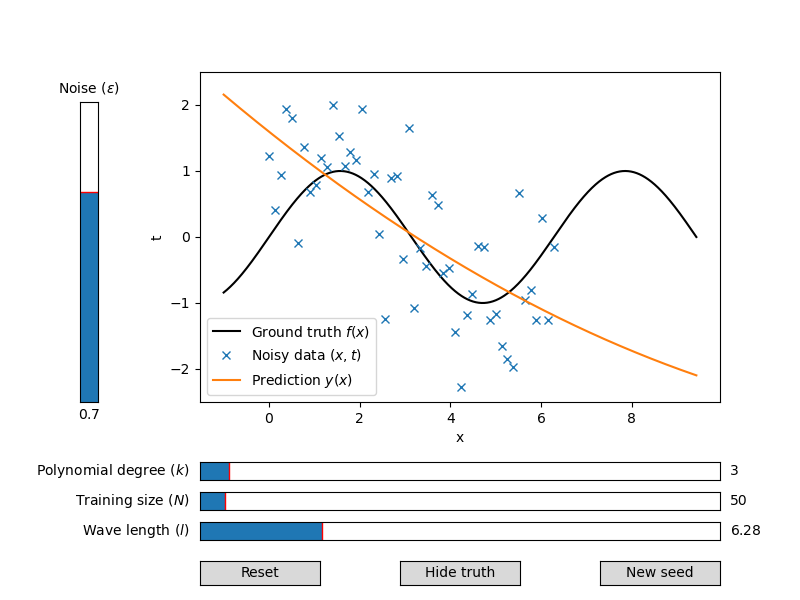

In [19]:
################
# Initial plot #
################

# Create an initial plot
fig, ax = plt.subplots(figsize=(8,6))
truth, = plt.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
data, = plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
pred, = plt.plot(x_pred, y_2, '-', label=r'Prediction $y(x)$')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_ylim((-2.5, 2.5))
plt.legend(loc='lower left')

# Adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.33)

###########
# Sliders #
###########

# Make a horizontal slider to control the degree of freedom
ax_k = plt.axes([0.25, 0.20, 0.65, 0.03])
k_slider = Slider(
    ax=ax_k,
    label=r'Polynomial degree ($k$)',
    valmin=2,
    valmax=20,
    valinit=3,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the number of measurements
ax_N = plt.axes([0.25, 0.15, 0.65, 0.03])
N_slider = Slider(
    ax=ax_N,
    label=r'Training size ($N$)',
    valmin=2,
    valmax=1000,
    valinit=N,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the wave length
ax_l = plt.axes([0.25, 0.10, 0.65, 0.03])
l_slider = Slider(
    ax=ax_l,
    label=r'Wave length ($l$)',
    valmin=0.5,
    valmax=8*np.pi,
    valinit=2*np.pi,
)

# Make a vertical slider to control the noise level
ax_eps = plt.axes([0.10, 0.33, 0.0225, 0.50])
eps_slider = Slider(
    ax=ax_eps,
    label=r'Noise ($\varepsilon$)',
    valmin=0,
    valmax=1,
    valinit=noise,
    orientation="vertical"
)

# Define an update function when a slider value changes
def update(event):
    
    global seed

    # Get the slider values
    k = int(min(k_slider.val, N_slider.val))
    N = int(N_slider.val)
    l = l_slider.val
    eps = eps_slider.val
    
    # Generate the noisy data again
    np.random.seed(seed)

    x = np.linspace(0, 2*np.pi, N)
    t = f(x, l) + np.random.normal(0, eps, N)
    
    # Update the ground truth and the data in the plots
    truth.set_data(x_pred, f(x_pred,l))
    data.set_data(x, t)
    
    # Fit the KNN to the updated data
    phi_poly = PolynomialBasis(k)
    w_poly = solve_least_squares(x, t, phi_poly)
    Phi_pred = phi_poly(x_pred)
    y_pred = np.matmul(Phi_pred, w_poly)
    pred.set_ydata(y_pred)
    
    fig.canvas.draw_idle()

# Connect the update function to each slider
k_slider.on_changed(update)
N_slider.on_changed(update)
l_slider.on_changed(update)
eps_slider.on_changed(update)

# Make a button to update the seed
ax_seed = plt.axes([0.75, 0.025, 0.15, 0.04])
seed_button = Button(ax_seed, 'New seed', hovercolor='0.975')

# Make a button to hide/show the truth
ax_truth = plt.axes([0.50, 0.025, 0.15, 0.04])
truth_button = Button(ax_truth, 'Hide truth', hovercolor='0.975')

# Make a button to go back to the initial settings
ax_reset = plt.axes([0.25, 0.025, 0.15, 0.04])
reset_button = Button(ax_reset, 'Reset', hovercolor='0.975')

# Define a function that changes the seed
def update_seed(event):
    
    global seed
    
    seed += 1
    
    update(event)

# Define a function that changes the seed
def toggle_truth(event):
    
    if truth.get_alpha() is None:
        truth.set_alpha(0)
        truth_button.label.set_text('Show truth')
    else:
        truth.set_alpha(None)
        truth_button.label.set_text('Hide truth')
        
    update(event)
    
# Define a function that performs a reset
def reset_all(event):
    
    global seed
    
    seed = 0
    
    k_slider.reset()
    N_slider.reset()
    l_slider.reset()
    eps_slider.reset()
    
    if not truth.get_alpha() is None:
        toggle_truth(event)

    update(event)

# Connect the correct function to each button
seed_button.on_clicked(update_seed)
truth_button.on_clicked(toggle_truth)
reset_button.on_clicked(reset_all)

plt.show()

A few questions that might have crossed your minds when playing with the tool:
- What happens if we have as many data points as parameters? $(k + 1 = N)$
- What happens if we have more model parameters than data? $(k + 1 > N)$
- We only have access to data in the interval $[0,2\pi]$. How well does our model extrapolate beyond the datarange?

## Other choices of basis functions

As mentioned previously, the polynomial basis is just one choice among many to define our model. Depending on the problem setting, a different set of basis functions might lead to better results. Another popular choice are the radial basis functions, given by

$$ \phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2}{2\ell^2}\right\}, $$

where $\phi_j$ is centered around $\mu_j$ and $l$ determines the width. Let's implement a `RadialBasisFunctions` class:

In [11]:
# Here is a class for the polynomials:
class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, mu, ell):
        self.mu = mu
        self.ell = ell
        self.num_basis = mu.shape[0]
    def __call__(self, x):
        
        Phi = np.ndarray((x.shape[0], self.num_basis))
        for i in range(self.num_basis):
            Phi[:,i] = np.exp(-.5 * (x - self.mu[i]) ** 2 / self.ell ** 2)
        return Phi

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
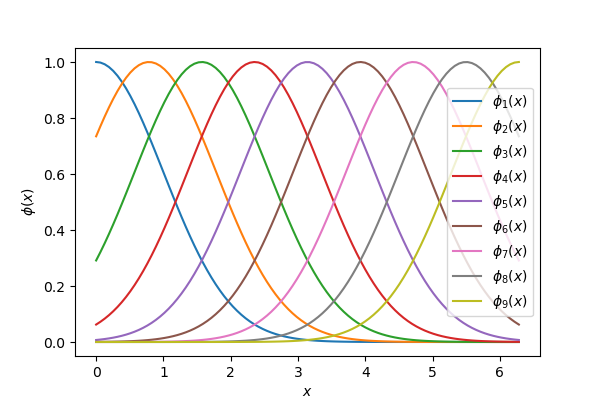

In [12]:
# Let's test our implementation
l_radial = 1.
N_radial = 9
mu = np.linspace(0,2*np.pi, N_radial)
phi_radial = RadialBasisFunctions(mu, l_radial)
x_test = np.linspace(0,2*np.pi,100)
Phi_radial_test = phi_radial(x_test)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

for i, row in enumerate(Phi_radial_test.transpose()):
    plt.plot(x_test, row, label=r'$\phi_{}(x)$'.format(i + 1))
    
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend()
plt.show()

One of the radial basis' attributes is the locality of its individual functions. This means data in one part of the domain will not impact predictions in other parts of the domain. Periodicity can be achieved with a Fourier basis. Wavelets are popular in signal processing since they are localized in both frequency and space. It is up to the user to determine which basis function properties are desired for a given problem. Try to implement some of these basis functions yourself and assess how well they compare with the pre-implemented ones.

Let's see how well the GLM with radial basis functions performs on the sine wave problem.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
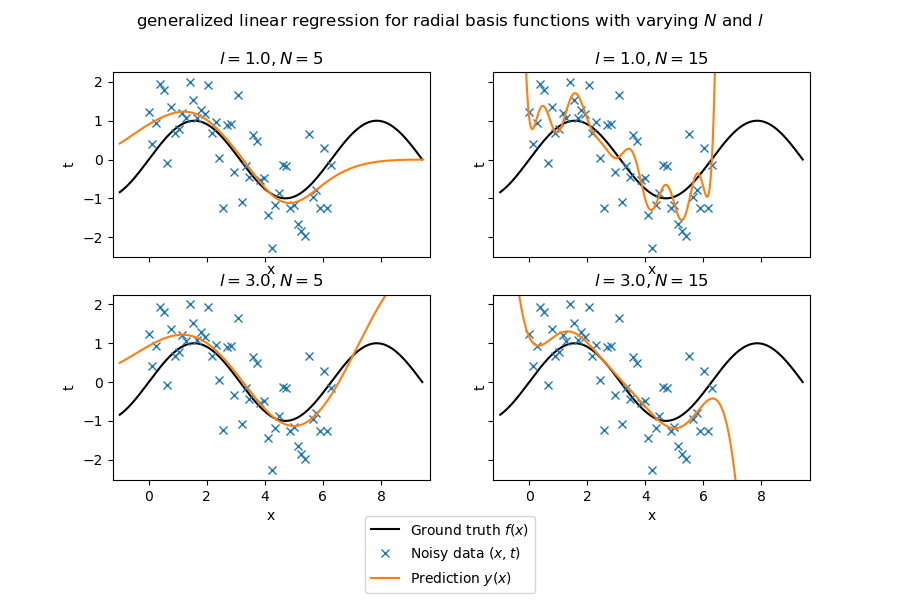

In [28]:
# Let's test the radial basis functions
N_radial = 5
l_radial = 1.0
Xc = np.linspace(0,2*np.pi, N_radial)
phi_radial = RadialBasisFunctions(Xc, l_radial)
w_radial = solve_least_squares(x, t, phi_radial)
y_5_1 = np.matmul(phi_radial(x_pred), w_radial)

N_radial = 15
l_radial = 1.0
Xc = np.linspace(0,2*np.pi, N_radial)
phi_radial = RadialBasisFunctions(Xc, l_radial)
w_radial = solve_least_squares(x, t, phi_radial)
y_15_1 = np.matmul(phi_radial(x_pred), w_radial)


N_radial = 5
l_radial = 3.0
Xc = np.linspace(0,2*np.pi, N_radial)
phi_radial = RadialBasisFunctions(Xc, l_radial)
w_radial = solve_least_squares(x, t, phi_radial)
y_5_3 = np.matmul(phi_radial(x_pred), w_radial)

N_radial = 15
l_radial = 3.0
Xc = np.linspace(0,2*np.pi, N_radial)
phi_radial = RadialBasisFunctions(Xc, l_radial)
w_radial = solve_least_squares(x, t, phi_radial)
y_15_3 = np.matmul(phi_radial(x_pred), w_radial)

# Define a function that creates a plot
def plot_pred(ax, y_k, l, N):
    
    margin = 0.25
    ax.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
    ax.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
    ax.plot(x_pred, y_k, '-', label=r'Prediction $y(x)$')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(r'$l = {}, N = {}$'.format(l, N))
    ax.set_xlim([np.min(x_pred) - margin, np.max(x_pred) + margin])
    ax.set_ylim([np.min(t) - margin, np.max(t) + margin])

# Plot the resulting predictions
# tight_layout=True or constrained_layout=True does not play nice with the legend :(
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for radial basis functions with varying $N$ and $l$')

# Plot for k=1
plot_pred(ax[0][0], y_5_1, 1.0, 5)

# Plot for k=10
plot_pred(ax[0][1], y_15_1, 1.0, 15)

# Plot for k=30
plot_pred(ax[1][0], y_5_3, 3.0, 5)

# Plot for k=100
plot_pred(ax[1][1], y_15_3, 3.0, 15)

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

The figure above shows four different combinations of the hyperparameters (number of basis functions and length scale). The quality of the fit depends strongly on the parameter setting, but a visual inspection indicates our model can replicate the general trend.

## Final remarks

This notebook introduced the generalized linear models to increase our model's flexibility. We have seen that increased flexibility is not always good if we perform a simple least-squares analysis. We know from the previous notebook that we can introduce a validation set to prevent our model from overfitting; however, we are wasting valuable data. The following lecture and its accompanying notebook will introduce you to different approaches to learning and how they enable us to elegantly control the model complexity.